# Transfusion

2024年8月 Meta AI 把 Transfusion 推出。其算是 Diffusion + Transformer 的一个统一。毕竟，图像生成主流看 Diffusion (SD, Midjourney...), 语言模型主流看 Transformer。这二者统一，恰好在这里有复现版！ [传送门](https://github.com/lucidrains/transfusion-pytorch)

我们看一看，从 Transfusion 起，模态统一的模型，就是一模型多任务的范式，里面代码逻辑长什么样？


由于源代码内容太长，这里决定从顶向下解读，并且通过带有一定运行来解读代码。

In [1]:
from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel
import inspectus
import torch

In [2]:
context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


In [3]:
text= 'The quick brown fox jumps over the lazy dog'
tokenized = tokenizer(
    text,
    return_tensors='pt',
    return_offsets_mapping=True
)
input_ids = tokenized['input_ids']

tokens = [text[s: e] for s, e in tokenized['offset_mapping'][0]]

In [4]:
with torch.no_grad():
    res = model(input_ids=input_ids.to(model.device), output_attentions=True)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
inspectus.attention(res['attentions'], tokens, 
          chart_types=['attention_matrix', 'query_token_heatmap', 'key_token_heatmap', 'dimension_heatmap', 'token_dim_heatmap', 'line_grid']
             ,color={
                 'query_token_heatmap': 'orange',
                 'key_token_heatmap': 'green',
                 'token_dim_heatmap': 'red',
             }
         )

Jetbrains IDE detected. Output might not be displayed properly. If any issue occurs please run in a jupyter notebook.


In [6]:
import numpy as np
import inspectus
arr = np.random.rand(3, 5)

inspectus.attention(arr, ['a', 'b', 'c'], [f'{i}' for i in range(5)])

Jetbrains IDE detected. Output might not be displayed properly. If any issue occurs please run in a jupyter notebook.


In [7]:
arr = np.random.rand(2, 3, 5)

inspectus.attention(arr, ['a', 'b', 'c'], [f'{i}' for i in range(5)])

Jetbrains IDE detected. Output might not be displayed properly. If any issue occurs please run in a jupyter notebook.


In [8]:
arr = np.random.rand(2, 2, 3, 5)

inspectus.attention(arr, ['a', 'b', 'c'], [f'{i}' for i in range(5)])

Jetbrains IDE detected. Output might not be displayed properly. If any issue occurs please run in a jupyter notebook.


In [9]:
context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


In [10]:
text= 'Contrary to popular belief, Lorem Ipsum is not simply random text. It has roots in a piece of classical Latin literature from 45 BC, making it over 2000 years old. Richard McClintock, a Latin professor at Hampden-Sydney College in Virginia, looked up one of the more obscure Latin words, consectetur, from a Lorem Ipsum passage, and going through the cites of the word in classical literature, discovered the undoubtable source. Lorem Ipsum comes from sections 1.10.32 and 1.10.33 of "de Finibus Bonorum et Malorum" (The Extremes of Good and Evil) by Cicero, written in 45 BC. This book is a treatise on the theory of ethics, very popular during the Renaissance. The first line of Lorem Ipsum, "Lorem ipsum dolor sit amet..", comes from a line in section 1.10.32. The standard chunk of Lorem Ipsum used since the 1500s is reproduced below for those interested. Sections 1.10.32 and 1.10.33 from "de Finibus Bonorum et Malorum" by Cicero are also reproduced in their exact original form, accompanied by English versions from the 1914 translation by H. Rackham.'
tokenized = tokenizer(
    text,
    return_tensors='pt',
    return_offsets_mapping=True
)
input_ids = tokenized['input_ids']

tokens = [text[s: e] for s, e in tokenized['offset_mapping'][0]]

In [11]:
with torch.no_grad():
    res = model(input_ids=input_ids.to(model.device), output_attentions=True)

In [12]:
from torch.nn.functional import nll_loss

logits = res['logits']
losses = []
entropies = []
token_info = []
for i in range(len(tokens)):
    loss = nll_loss(logits[0, i], input_ids[0, i])
    losses.append(loss.item())
    
    entropy = -torch.sum(torch.nn.functional.softmax(logits[0, i]) * torch.nn.functional.log_softmax(logits[0, i]))
    entropies.append(entropy.item())

    pred_token_indices = torch.argsort(logits[0, i])[:5]
    pred_tokens = [tokenizer.decode([idx]) for idx in pred_token_indices]
    token_info.append(f"pred 1: {pred_tokens[0]}\npred 2: {pred_tokens[1]}\npred 3: {pred_tokens[2]}\npred 4: {pred_tokens[3]}\npred 5: {pred_tokens[4]}")

C:\Users\wangy\AppData\Local\Temp\ipykernel_16184\2345997088.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  entropy = -torch.sum(torch.nn.functional.softmax(logits[0, i]) * torch.nn.functional.log_softmax(logits[0, i]))
C:\Users\wangy\AppData\Local\Temp\ipykernel_16184\2345997088.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  entropy = -torch.sum(torch.nn.functional.softmax(logits[0, i]) * torch.nn.functional.log_softmax(logits[0, i]))


In [13]:
inspectus.tokens(tokens, {"loss": losses, "entropy": entropies}, token_info=token_info, theme="light")

Jetbrains IDE detected. Output might not be displayed properly. If any issue occurs please run in a jupyter notebook.


In [16]:
import inspectus

inspectus.distribution({'x': [x for x in range(0, 100)]})

alt.VConcatChart(...)

In [17]:
import numpy as np

def random_loss():
    return np.array([[1/x**2 + var/5 for var in np.random.rand(100)] for x in np.linspace(1, 5, num=500)])

train_loss = random_loss()
valid_loss = random_loss()+1

inspectus.distribution({'training_loss': train_loss, 'validation_loss': valid_loss})

alt.VConcatChart(...)

In [18]:
# Not showing mean
inspectus.distribution({'training_loss': train_loss, 'validation_loss': valid_loss}, include_mean=False)

alt.VConcatChart(...)

In [19]:
# showing borders
inspectus.distribution({'training_loss': train_loss, 'validation_loss': valid_loss}, include_borders=True)

alt.VConcatChart(...)

In [20]:
from inspectus import data_logger

d_log = inspectus.data_logger.DataLogger('sample')
d_log.clear()
for i, entry in enumerate(train_loss):
    d_log.save('train_loss', entry, i)
for i, entry in enumerate(valid_loss):
    d_log.save('valid_loss', entry, i)
    
tl = d_log.read('train_loss')
vl = d_log.read('valid_loss')

inspectus.distribution({'training_loss': train_loss, 'validation_loss': valid_loss})

HTML(value='<pre  style="overflow-x: scroll;">Create c:\\Users\\wangy\\Desktop\\all works\\MathTowarsAI\\Reimp…

alt.VConcatChart(...)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [23]:
import inspectus.data_logger

step = 0
d_log = inspectus.data_logger.DataLogger('logs/mnist')
d_log.clear()
def train(model, device, train_loader, optimizer, epoch):
    global step
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if loss.item() < 2.0:
            with torch.no_grad():
                d_log.save('train_loss', F.nll_loss(output, target, reduction='none'), step)
                step += 1

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
torch.manual_seed(1)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.05)

HTML(value='<pre  style="overflow-x: scroll;">Using c:\\Users\\wangy\\Desktop\\all works\\MathTowarsAI\\Reimpl…

In [24]:
for epoch in range(2):
    train(model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326473
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.552778
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.322657
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.330265
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.283358
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.218161
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.346010
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.227615
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.240313
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.234440
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.413427
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.287319
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.151574
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.179537
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.083700
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.086231
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.060757
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.095649
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.136611
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.120402


In [25]:
torch.save(model.state_dict(), "mnist_cnn.pt")

In [26]:
tl = d_log.read('train_loss')
inspectus.distribution({'train_loss': tl})

alt.VConcatChart(...)

In [27]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

C:\Users\wangy\AppData\Local\Temp\ipykernel_16184\1754197020.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_cnn.pt"))


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [28]:
from torchvision import datasets

torch.manual_seed(1)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('../data', download=True, train=False,
                          transform=transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000)

In [29]:
data, target = next(iter(train_loader))
data = data.to(device)
target = target.to(device)

output = model(data.to(device))
loss = F.nll_loss(output, target.to(device), reduction='none')

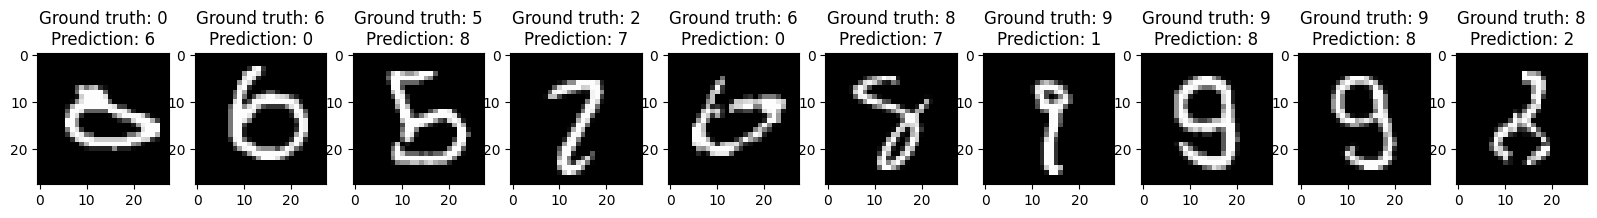

In [30]:
import matplotlib.pyplot as plt

top_losses = torch.topk(loss, 10)
fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(data[top_losses.indices[i]].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[i].set_title(f"Ground truth: {target[top_losses.indices[i]].item()}\nPrediction: {output[top_losses.indices[i]].argmax().item()}")